# Aleph2Image: CLIP + DALL-E for text to image generation
Copyright © [@advadnoun](https://twitter.com/advadnoun) on Twitter, and OpenAI for [CLIP](https://github.com/openai/CLIP) and [DALL-E](https://github.com/openai/DALL-E/).




In [ ]:
# sample verse
text_input = '''And in the emptiness between the palms and what was forgotten by clouds'''

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

CUDA version: 11.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html


# Imports


In [ ]:
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob

from google.colab import output



In [ ]:
# GPU Stat

!nvidia-smi -L


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b139d414-c3a9-203d-8168-0747ab036ae6)


# Perceptor

In [ ]:


%cd /content/

!git clone https://github.com/openai/CLIP.git


%cd /content/CLIP/

!pip install ftfy

import os
import clip
import torch

clip.available_models()

import numpy as np

# Load the model
perceptor, preprocess = clip.load('ViT-B/32', jit=True)
perceptor = perceptor.eval()

/content
fatal: destination path 'CLIP' already exists and is not an empty directory.
/content/CLIP


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

# Params

In [ ]:
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape
batch_size = 1

In [ ]:
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')
  

# Generator

In [ ]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

!pip install git+https://github.com/openai/DALL-E.git


from dall_e import map_pixels, unmap_pixels, load_model
target_image_size = sideX

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)


model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')
encoder = load_model("https://cdn.openai.com/dall-e/encoder.pkl", 'cuda')


  Cloning https://github.com/openai/DALL-E.git to /tmp/pip-req-build-0ct90_tz
  Running command git clone -q https://github.com/openai/DALL-E.git /tmp/pip-req-build-0ct90_tz


In [ ]:
oi = encoder(map_pixels(.2*torch.nn.functional.interpolate(torch.rand(1, 3, sideX//4, sideY//4), (sideX, sideY))).cuda())

# Latent coordinates

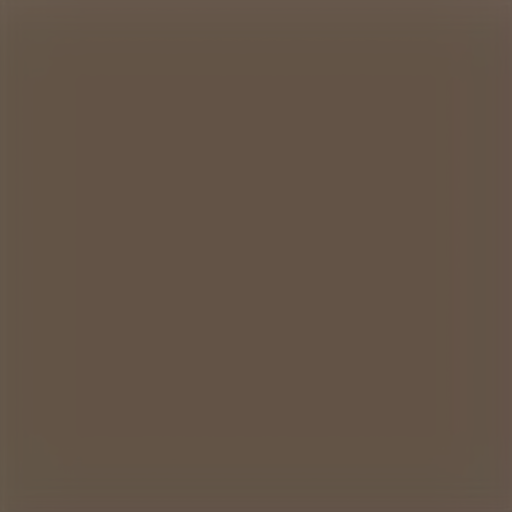

In [ ]:
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        hots = torch.nn.functional.one_hot((torch.arange(0, 8192).to(torch.int64)), num_classes=8192)
        rng = torch.zeros(batch_size, 64*64, 8192).uniform_()**torch.zeros(batch_size, 64*64, 8192).uniform_(.1,1)
        for b in range(batch_size):
          for i in range(64**2):
            rng[b,i] = hots[[np.random.randint(8191)]]
        rng = rng.permute(0, 2, 1)
        self.normu = torch.nn.Parameter(rng.cuda().view(batch_size, 8192, 64, 64))

    def forward(self):
      normu = torch.softmax(hadies*self.normu.reshape(batch_size, 8192//2, -1), dim=1).view(batch_size, 8192, 64, 64)
      return normu

lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.Adam([{'params': mapper, 'lr': .05}])
eps = 0

tx = clip.tokenize(text_input)
t = perceptor.encode_text(tx.cuda()).detach().clone()

nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

will_it = False
hadies = 1.
with torch.no_grad():
  al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
  for allls in al:
    displ(allls[:3])
    print('\n')

# Train

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



  ##########################################################
   

[0, tensor([-2.1855], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 0


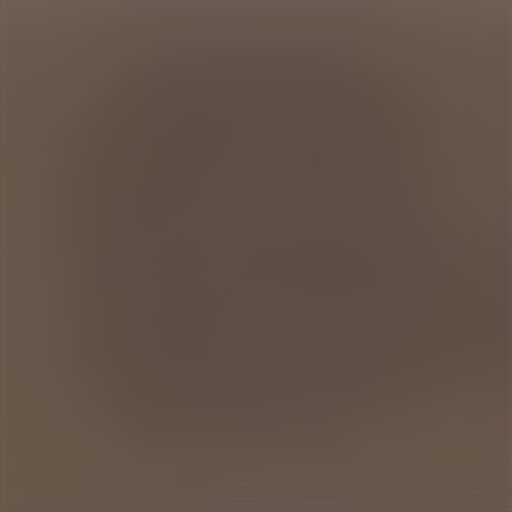




  ##########################################################
   

[0, tensor([-3.2617], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 50


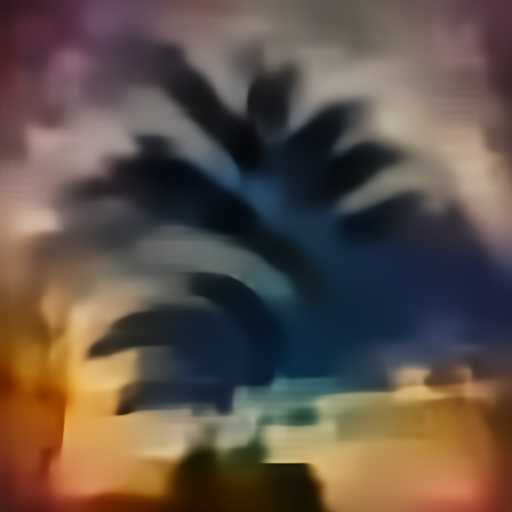




  ##########################################################
   

[0, tensor([-3.7129], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 100


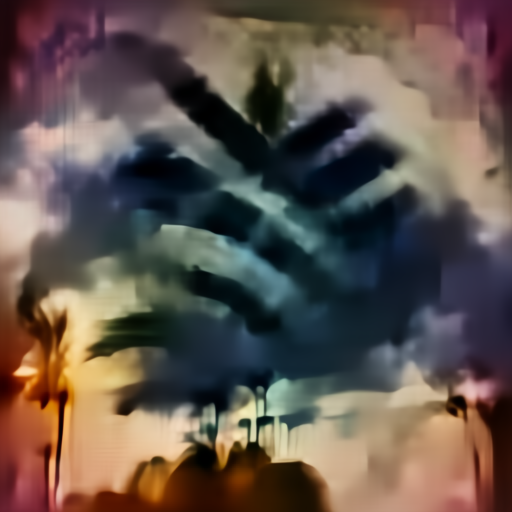




  ##########################################################
   

[0, tensor([-3.8203], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 150


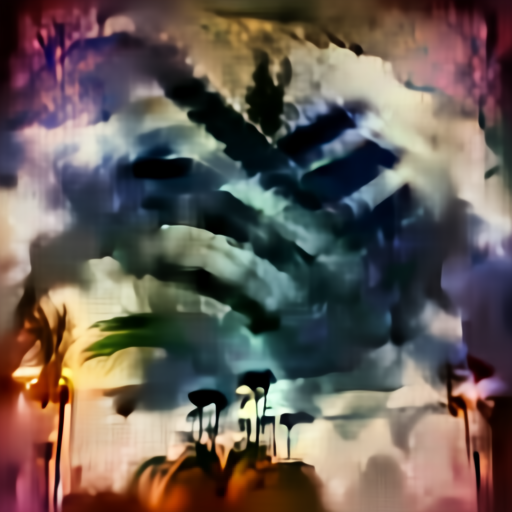




  ##########################################################
   

[0, tensor([-4.1094], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 200


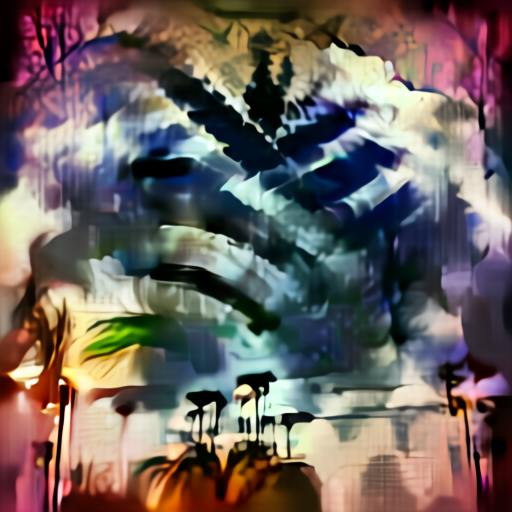




  ##########################################################
   

[0, tensor([-4.4688], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 250


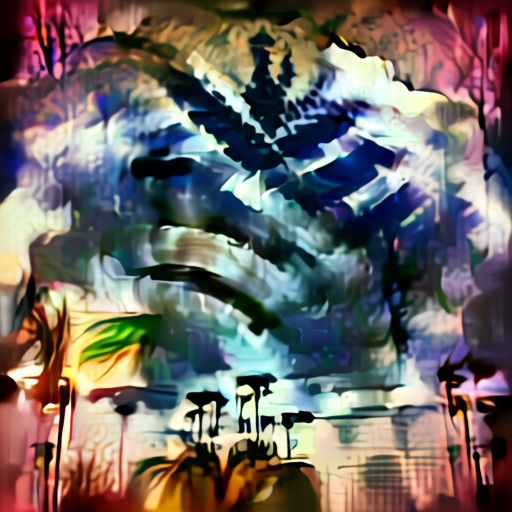




  ##########################################################
   

[0, tensor([-4.6055], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 300


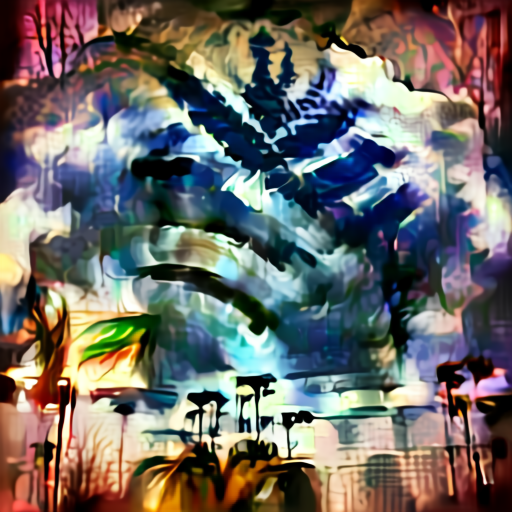




  ##########################################################
   

[0, tensor([-4.7109], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 350


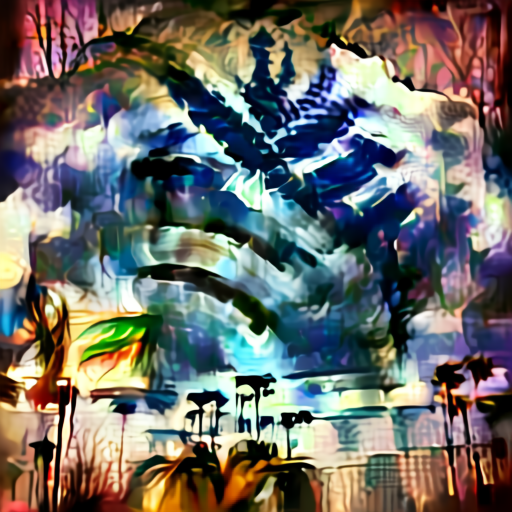




  ##########################################################
   

[0, tensor([-4.4219], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 400


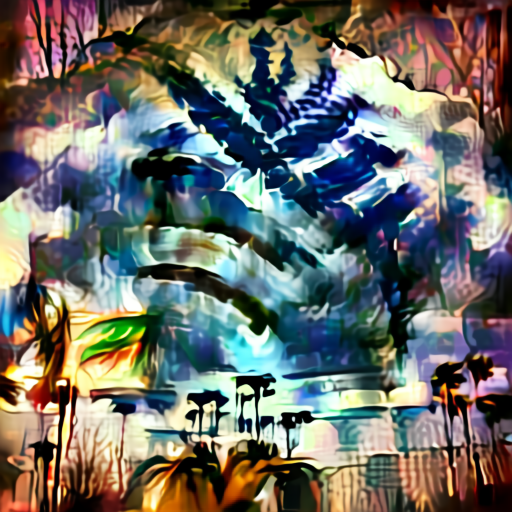




  ##########################################################
   

[0, tensor([-4.6641], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 450


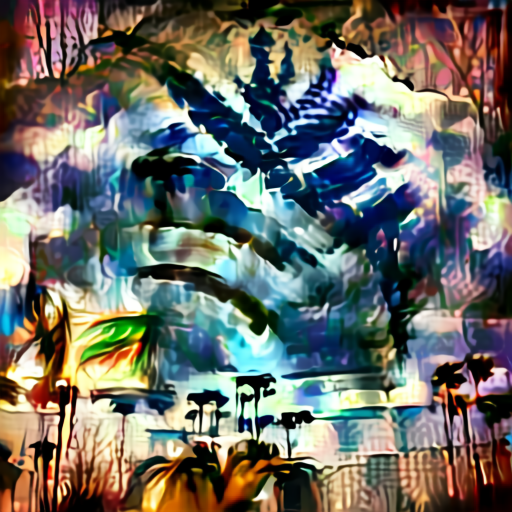




  ##########################################################
   

[0, tensor([-4.7109], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 500


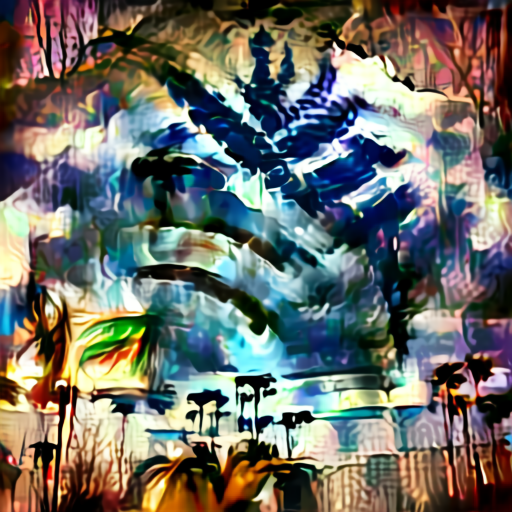




  ##########################################################
   

[0, tensor([-4.7578], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 550


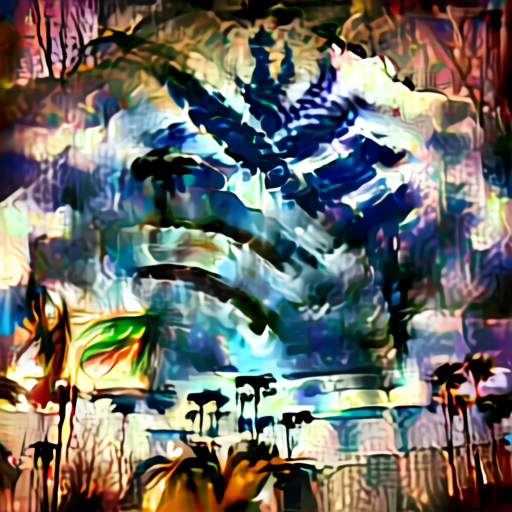




  ##########################################################
   

[0, tensor([-4.3672], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 600


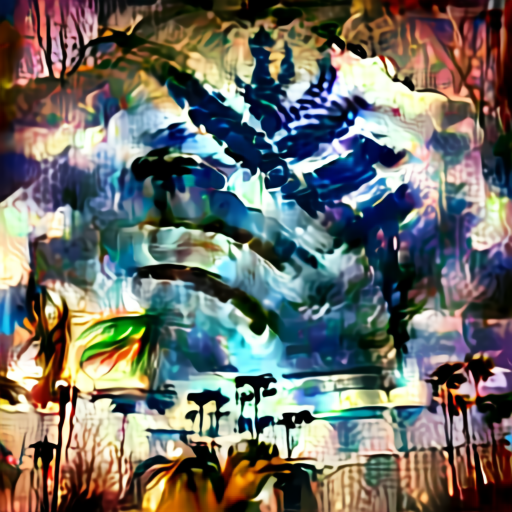




  ##########################################################
   

[0, tensor([-4.5273], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 650


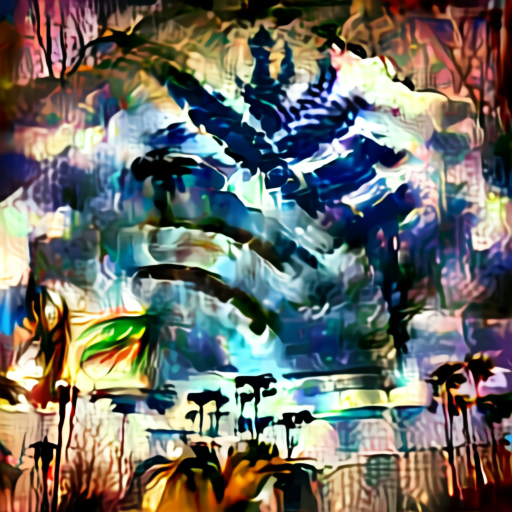




  ##########################################################
   

[0, tensor([-4.5938], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 700


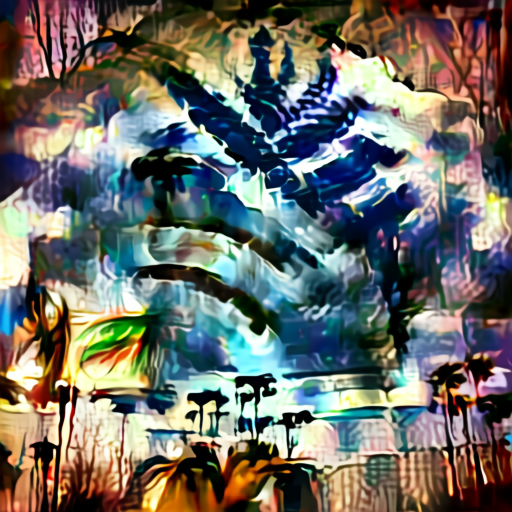




  ##########################################################
   

[0, tensor([-4.7344], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 750


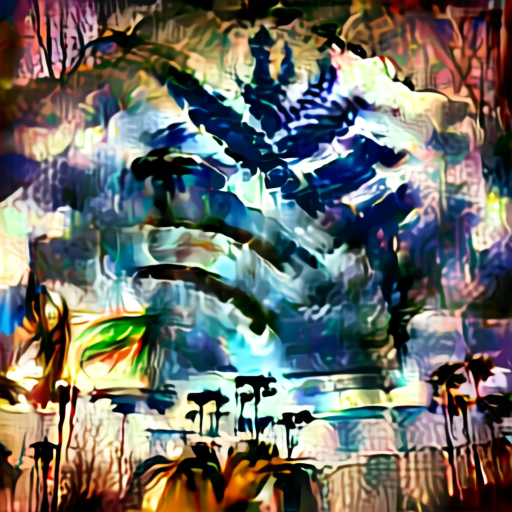




  ##########################################################
   

[0, tensor([-4.7344], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 800


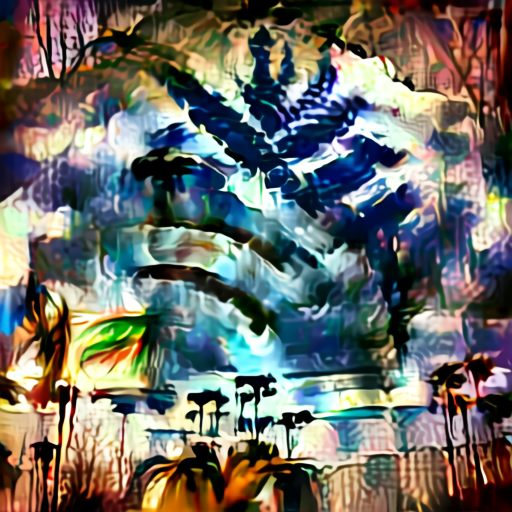

KeyboardInterrupt: ignored

In [ ]:
def checkin(loss):
  global hadies
  print('''##########################################################''',loss, ' (loss)\n',itt)
  with torch.no_grad():  
    al = unmap_pixels(torch.sigmoid(model(lats())[:, :3]).cpu().float()).numpy()
    for allls in al:
      displ(allls)
      display.display(display.Image(str(3)+'.png'))
      print('\n')

  output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')

def ascend_txt():
  out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))

  cutn = 64
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).uniform_(.8, .99))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = torch.cat(p_s, 0)

  into = into + .2 * random.random() * torch.randn_like(into)

  into = nom((into))


  iii = perceptor.encode_image(into)

  lat_l = 0
  return [lat_l, 10*-torch.cosine_similarity(t, iii).view(-1, batch_size).T.mean(1)]

def train(i):
  global hadies
  loss1 = ascend_txt()
  loss = loss1[0] + loss1[1]
  loss = loss.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  for g in optimizer.param_groups:
    g['lr'] = g['lr']*1.005
    
  if itt % 50 == 0:
    checkin(loss1)


itt = 0
for asatreat in range(10000):
  train(itt)
  itt+=1